In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
import os
import numpy as np
matplotlib.rcParams['pdf.fonttype'] = 42

#fabian dic 
fabian_remap_jaspar = {}
with open("/home/mouren/Data/variants/tcga_MC3/fabian/fabian_precise_snp_tcga_full_list_RemapJaspar.tsv") as file:
    for line in file:
        values = list(map(float, line.split()[1:]))
        fabian_remap_jaspar[line.split()[0]] = max(abs(val) for val in values)

fabian_jaspar = {}
with open("/home/mouren/Data/article_repo_data/PanCan_analyse/fabian_precise_snp_tcga_full_list_onlyJaspar.tsv") as file:
    for line in file:
        values = list(map(float, line.split()[1:]))
        fabian_jaspar[line.split()[0]] = max(abs(val) for val in values)

# df of snps
df_snps = pd.read_csv("/home/mouren/Data/article_repo_data/PanCan_analyse/tcga_snp_exonhancers_SortedByCancer_hg19.tsv", sep="\t", header=None,index_col=None)
df_snps['fab_id'] = df_snps[0] + ':' + df_snps[8].astype(str) + df_snps[10] + '>' + df_snps[11]
df_snps['patient_column'] = df_snps[14].str[:16]

In [31]:
all_result_jaspar = {}
syn_result_jaspar = {}
all_result_jasparremap = {}
syn_result_jasparremap = {}
with open("/home/mouren/Data/article_repo_data/PanCan_analyse/deseq2/all_sig_uniq.tsv") as file:
    for line in file:
        if line.strip().split()[0] == "all":
            if line.strip().split()[1] not in all_result_jaspar:
                all_result_jasparremap[line.strip().split()[1]] = [0,0,0,0]
                all_result_jaspar[line.strip().split()[1]] = [0,0,0,0]

            filtered_df = df_snps[df_snps[3] == line.strip().split()[2]]
            
            best_score_in_exon_remap_jaspar = 0
            best_score_in_exon_jaspar = 0
            for index, row in filtered_df.iterrows():
                try:
                    score = fabian_remap_jaspar[row['fab_id']]
                    if score > best_score_in_exon_remap_jaspar:
                        best_score_in_exon_remap_jaspar = score
                except KeyError: #no fabian data
                    continue
                try:
                    score = fabian_jaspar[row['fab_id']]
                    if score > best_score_in_exon_jaspar:
                        best_score_in_exon_jaspar = score
                except KeyError: #no fabian data
                    continue

            if best_score_in_exon_remap_jaspar == 0:
                all_result_jasparremap[line.strip().split()[1]][3] += 1
            elif best_score_in_exon_remap_jaspar < 0.33:
                all_result_jasparremap[line.strip().split()[1]][0] += 1
            elif best_score_in_exon_remap_jaspar < 0.66:
                all_result_jasparremap[line.strip().split()[1]][1] += 1
            else:
                all_result_jasparremap[line.strip().split()[1]][2] += 1           

            if best_score_in_exon_jaspar == 0:
                all_result_jaspar[line.strip().split()[1]][3] += 1
            elif best_score_in_exon_jaspar < 0.33:
                all_result_jaspar[line.strip().split()[1]][0] += 1
            elif best_score_in_exon_jaspar < 0.66:
                all_result_jaspar[line.strip().split()[1]][1] += 1
            else:
                all_result_jaspar[line.strip().split()[1]][2] += 1
        
        else: #for synonymous
            if line.strip().split()[1] not in syn_result_jaspar:
                syn_result_jasparremap[line.strip().split()[1]] = [0,0,0,0]
                syn_result_jaspar[line.strip().split()[1]] = [0,0,0,0]

            patients_list = [x for x in (line.strip().split()[3]).split(",")]

            filtered_df1 = df_snps[df_snps[3] == line.strip().split()[2]] #get exon
            filtered_df2 = filtered_df1[filtered_df1[12] == "Silent"] #get only silent snps 
            filtered_df3 = filtered_df2[filtered_df2["patient_column"].isin(patients_list)]

            best_score_in_exon_remap_jaspar = 0
            best_score_in_exon_jaspar = 0
            for index, row in filtered_df3.iterrows():
                try:
                    score = fabian_remap_jaspar[row['fab_id']]
                    if score > best_score_in_exon_remap_jaspar:
                        best_score_in_exon_remap_jaspar = score
                except KeyError: #no fabian data
                    continue
                try:
                    score = fabian_jaspar[row['fab_id']]
                    if score > best_score_in_exon_jaspar:
                        best_score_in_exon_jaspar = score
                except KeyError: #no fabian data
                    continue

            if best_score_in_exon_remap_jaspar < 0.33:
                syn_result_jasparremap[line.strip().split()[1]][0] += 1
            elif best_score_in_exon_remap_jaspar < 0.66:
                syn_result_jasparremap[line.strip().split()[1]][1] += 1
            else:
                syn_result_jasparremap[line.strip().split()[1]][2] += 1           

            if best_score_in_exon_jaspar < 0.33:
                syn_result_jaspar[line.strip().split()[1]][0] += 1
            elif best_score_in_exon_jaspar < 0.66:
                syn_result_jaspar[line.strip().split()[1]][1] += 1
            else:
                syn_result_jaspar[line.strip().split()[1]][2] += 1

In [32]:
# put missing keys into dictionnary 
cat_order = ['UVM', 'THCA', 'PCPG', 'LAML', 'THYM', 'TGCT', 'KICH', 'ACC', 'PRAD',
       'LGG', 'MESO', 'PAAD', 'CHOL', 'BRCA', 'SARC', 'KIRC', 'UCS', 'GBM',
       'KIRP', 'OV', 'LIHC', 'UCEC', 'DLBC', 'CESC', 'READ', 'ESCA', 'HNSC',
       'COAD', 'STAD', 'BLCA', 'LUAD', 'LUSC', 'SKCM']

for i in cat_order:
    if i not in all_result_jaspar:
        all_result_jaspar[i] = [0,0,0,1]
    if i not in syn_result_jaspar:
        syn_result_jaspar[i] = [0,0,0,1]
    if i not in all_result_jasparremap:
        all_result_jasparremap[i] = [0,0,0,1]
    if i not in syn_result_jasparremap:
        syn_result_jasparremap[i] = [0,0,0,1]

cat_order.reverse()
res_jaspar_all = {key: all_result_jaspar[key] for key in cat_order} #desired_order_exonhancers
res_jaspar_syn = {key: syn_result_jaspar[key] for key in cat_order} #desired_order_exonhancers

/tmp/ipykernel_242346/1165225204.py:55: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


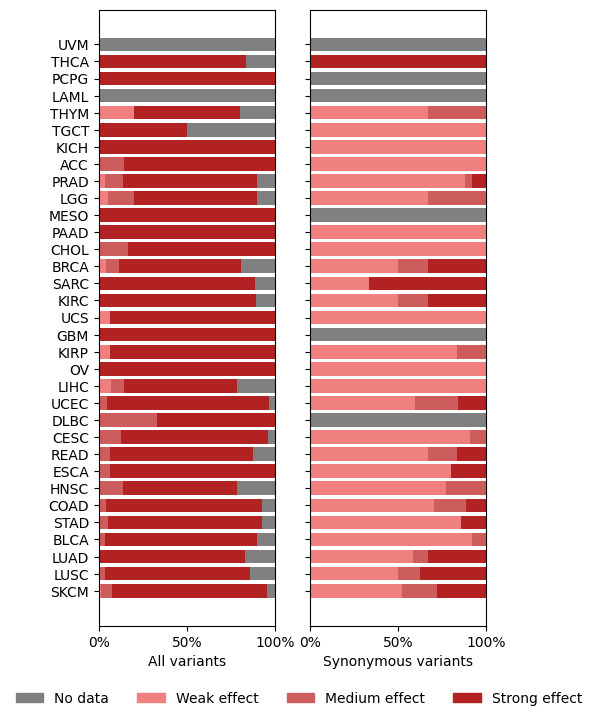

In [ ]:
colors = ['lightcoral', 'indianred', 'firebrick', 'gray']  # Increasing red intensity and gray

fig, ax = plt.subplots(1,2,figsize=(5, 8), sharey=True)

###all
categories = list(res_jaspar_all.keys())
# Plot each category as a stacked horizontal bar
for i, (key, values) in enumerate(res_jaspar_all.items()):
    values = np.array(values)
    total = values.sum()
    normalized_values = values / total  # Convert to percentages
    left = 0  # Start position for stacking

    for j in range(len(values)):
        ax[0].barh(key, normalized_values[j], left=left, color=colors[j]) #, edgecolor='black')
        left += normalized_values[j]  # Update left position for next bar
ax[0].set_xticks([0,0.5,1],["0%","50%","100%"])

ax[0].set_xlabel("All variants")

###syn
categories = list(res_jaspar_syn.keys())
# Plot each category as a stacked horizontal bar
for i, (key, values) in enumerate(res_jaspar_syn.items()):
    values = np.array(values)
    total = values.sum()
    normalized_values = values / total  # Convert to percentages
    left = 0  # Start position for stacking

    for j in range(len(values)):
        ax[1].barh(key, normalized_values[j], left=left, color=colors[j]) #, edgecolor='black')
        left += normalized_values[j]  # Update left position for next bar

ax[1].set_xticks([0,0.5,1],["0%","50%","100%"])

ax[1].set_xlabel("Synonymous variants")

#legend 
# Create custom legends (only add one set of legends for clarity)
outer_legend_patches = [
    mpatches.Patch(color='gray', label='No data'),
    mpatches.Patch(color='lightcoral', label='Weak effect'),
    mpatches.Patch(color='indianred', label='Medium effect'),
    mpatches.Patch(color='firebrick', label='Strong effect'),
]

ax_middle_column = axes[-1, 1]
box = ax_middle_column.get_position()
center_x = (box.x0 + box.x1) / 2

# Add legend to the figure (only once, positioned outside the plot)
plt.legend(handles=outer_legend_patches,loc='lower center',bbox_to_anchor=(center_x-0.34, -0.15),  ncol=4, frameon=False)


plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/main_figures/fig6/tcga_deseq_fabian_jaspar_fig5e.pdf", format="pdf", bbox_inches="tight")
plt.savefig("/home/mouren/Images/tls1/main_figures/fig6/tcga_deseq_fabian_jaspar_fig5e.png", format="png", bbox_inches="tight")

plt.show()
